In [ ]:
!pip install ipython==7.34.0 ipykernel==5.5.6
!pip install import_ipynb

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom, gaussian_filter
from skimage.filters import threshold_otsu

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import math

from google.colab import drive
drive.mount('/content/drive')
import os
import import_ipynb
import imageio
import scipy.signal
from scipy.ndimage import gaussian_filter


path = '/content/drive/MyDrive/Colab Notebooks/Physics-Informed Neural Networks/Demo/fenics_cfd/neural_network'
os.chdir(path)

Mounted at /content/drive


In [ ]:
from visualize_geometry import plot_numpy_matrices, plot_with_transparent_mask
from data_io import get_joined_files, FlowFieldDataset, train_test_split
from data_processing import segment_vessel_otsu, sample_points_from_mask

In [ ]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)

In [ ]:
def gaussian_kernel(size=3, sigma=1):

    gauss = scipy.signal.windows.gaussian(size, std=sigma)
    kernel = np.outer(gauss, gauss)
    kernel = kernel / kernel.sum()

    return kernel

class GaussianBlur(nn.Module):
    def __init__(self, channels, kernel_size=3, sigma=1):
        super(GaussianBlur, self).__init__()
        kernel = gaussian_kernel(kernel_size, sigma)
        kernel = torch.from_numpy(kernel).float().unsqueeze(0).unsqueeze(0)
        kernel = kernel.repeat(channels, 1, 1, 1)
        self.weight = nn.Parameter(data=kernel, requires_grad=False)
        self.groups = channels
        self.conv = nn.Conv2d(channels, channels, kernel_size=kernel_size, groups=self.groups, bias=False, padding=kernel_size//2)

    def forward(self, x):
        self.conv.weight = self.weight
        return self.conv(x)


In [ ]:
class SuperResolutionCNN(nn.Module):
    def __init__(self, hidden_layers, dropout_rate=0.5, blur_kernel_size=5, blur_sigma=1.5):
        super(SuperResolutionCNN, self).__init__()
        self.swish = Swish()
        self.dropout = nn.Dropout(dropout_rate)
        self.batch_norm = nn.BatchNorm2d(hidden_layers[0])

        self.velocity_blur = GaussianBlur(channels=2, kernel_size=blur_kernel_size, sigma=blur_sigma)
        self.pressure_blur = GaussianBlur(channels=1, kernel_size=blur_kernel_size, sigma=blur_sigma)

        self.velocity_input_conv = nn.Conv2d(2, hidden_layers[0], kernel_size=3, padding=1)
        self.pressure_input_conv = nn.Conv2d(1, hidden_layers[0], kernel_size=3, padding=1)

        self.upsample = nn.Upsample(scale_factor=7, mode='bicubic', align_corners=True)

        self.conv_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()

        for i in range(1, len(hidden_layers)):
            self.conv_layers.append(nn.Conv2d(hidden_layers[i-1], hidden_layers[i], kernel_size=3, padding=1))
            self.bn_layers.append(nn.BatchNorm2d(hidden_layers[i]))

        self.velocity_output_conv = nn.Conv2d(hidden_layers[-1], 2, kernel_size=3, padding=1)
        self.pressure_output_conv = nn.Conv2d(hidden_layers[-1], 1, kernel_size=3, padding=1)

    def forward(self, velocity_input, pressure_input):

        velocity = self.velocity_blur(velocity_input)
        velocity = self.upsample(velocity)
        velocity = self.velocity_blur(velocity)
        velocity = self.velocity_input_conv(velocity)
        velocity = self.swish(self.batch_norm(velocity))
        velocity = self.dropout(velocity)
        for conv_layer, bn_layer in zip(self.conv_layers, self.bn_layers):
            velocity = conv_layer(velocity)
            velocity = self.swish(bn_layer(velocity))
            velocity = self.dropout(velocity)
        velocity_output = self.velocity_output_conv(velocity)

        pressure = self.pressure_blur(pressure_input)
        pressure = self.upsample(pressure)
        pressure = self.pressure_blur(pressure)
        pressure = self.pressure_input_conv(pressure)
        pressure = self.swish(self.batch_norm(pressure))
        pressure = self.dropout(pressure)
        for conv_layer, bn_layer in zip(self.conv_layers, self.bn_layers):
            pressure = conv_layer(pressure)
            pressure = self.swish(bn_layer(pressure))
            pressure = self.dropout(pressure)
        pressure_output = self.pressure_output_conv(pressure)

        return velocity_output, pressure_output

In [ ]:
def relative_error_loss(output, target):
    epsilon = 1e-6
    loss = torch.mean(torch.abs((output - target) / (target + epsilon)))
    return loss


In [ ]:
def train_model(model, train_loader, optimizer, criterion, num_epochs, n_iterations, device):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, ((u_hr, p_hr), (u_lr, p_lr)) in enumerate(train_loader):
            u_hr, p_hr = u_hr.to(device), p_hr.to(device)
            u_lr, p_lr = u_lr.to(device), p_lr.to(device)

            optimizer.zero_grad()
            u_pred, p_pred = model(u_lr, p_lr)

            loss = (criterion(u_pred, u_hr) + criterion(p_pred, p_hr))

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (i + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {running_loss / 10}')
                running_loss = 0.0

In [ ]:
def test_model(model, test_loader, criterion, num_visualizations, device):
  model.eval()

  with torch.no_grad():

    total_loss = 0
    for i, ((u_hr, p_hr), (u_lr, p_lr)) in enumerate(test_loader):

      u_hr, p_hr = u_hr.to(device), p_hr.to(device)
      u_lr, p_lr = u_lr.to(device), p_lr.to(device)

      u_pred, p_pred = model(u_lr, p_lr)
      total_loss += (criterion(u_pred, u_hr) + criterion(p_pred, p_hr)).item()

      if i < num_visualizations:
        u_pred_np = u_pred.cpu().numpy()
        p_pred_np = p_pred.cpu().numpy()
        u_hr_np = u_hr.cpu().numpy()
        p_hr_np = p_hr.cpu().numpy()

        for j in range(u_pred_np.shape[0]):
            plot_numpy_matrices(u_hr_np[j].transpose(1, 2, 0), p_hr_np[j][0], main_title="True Flow Field", plot_size=6)
            plot_numpy_matrices(u_pred_np[j].transpose(1, 2, 0), p_pred_np[j][0], main_title="Predicted Flow Field", plot_size=6)

    print(f'Test Loss: {total_loss / len(test_loader)}')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Device {device}')

if device.type == 'cuda':
  print(torch.cuda.get_device_name())
  torch.cuda.empty_cache()

Device cuda
Tesla T4


In [ ]:
npy_velocity_dir = '/content/drive/MyDrive/Colab Notebooks/Physics-Informed Neural Networks/Demo/fenics_cfd/blood_flow_simulations/velocity_fields/npy_data'
npy_pressure_dir = '/content/drive/MyDrive/Colab Notebooks/Physics-Informed Neural Networks/Demo/fenics_cfd/blood_flow_simulations/pressure_fields/npy_data'

joined_files_true = get_joined_files(npy_velocity_dir, npy_pressure_dir, 'true_data')
joined_files_noisy = get_joined_files(npy_velocity_dir, npy_pressure_dir, 'noisy_data')

dataset = FlowFieldDataset(npy_velocity_dir, npy_pressure_dir, joined_files_true, joined_files_noisy)
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2)

In [ ]:
batch_size = 1
num_epochs = 10
total_samples = len(train_dataset)
n_iterations = math.ceil(total_samples / batch_size)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

hidden_layers = np.array([64, 128, 128, 64])
model = SuperResolutionCNN(hidden_layers).to(device)
criterion = torch.nn.MSELoss()
# criterion = relative_error_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

train_model(model, train_loader, optimizer, criterion, num_epochs, n_iterations, device)

Epoch [1/10], Step [10/644], Loss: 0.5356296002864838
Epoch [1/10], Step [20/644], Loss: 0.4156514830887318
Epoch [1/10], Step [30/644], Loss: 0.24473082274198532
Epoch [1/10], Step [40/644], Loss: 0.9284708581864833
Epoch [1/10], Step [50/644], Loss: 0.7829399175941945
Epoch [1/10], Step [60/644], Loss: 0.4794352054595947
Epoch [1/10], Step [70/644], Loss: 0.4153923638164997
Epoch [1/10], Step [80/644], Loss: 0.6566594295203686
Epoch [1/10], Step [90/644], Loss: 0.11432104557752609
Epoch [1/10], Step [100/644], Loss: 0.11686618216335773
Epoch [1/10], Step [110/644], Loss: 0.40601039193570615
Epoch [1/10], Step [120/644], Loss: 0.16562258936464785
Epoch [1/10], Step [130/644], Loss: 0.10708633959293365
Epoch [1/10], Step [140/644], Loss: 1.2817289408296346
Epoch [1/10], Step [150/644], Loss: 0.1259554520249367
Epoch [1/10], Step [160/644], Loss: 0.2370403841137886
Epoch [1/10], Step [170/644], Loss: 0.6968971498310566
Epoch [1/10], Step [180/644], Loss: 2.031638149917126
Epoch [1/10], 

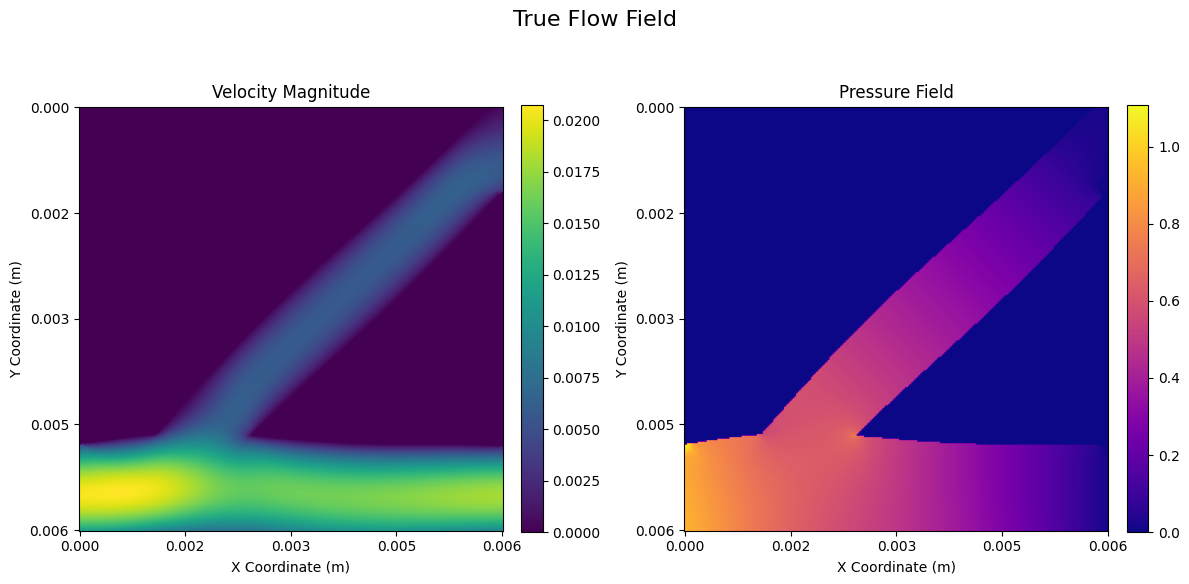

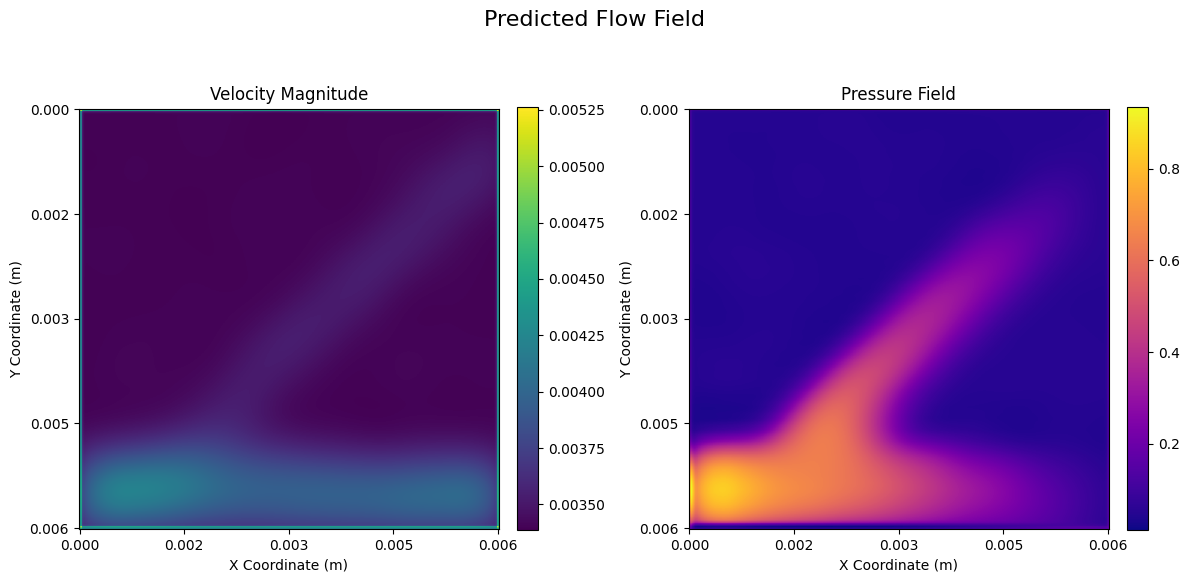

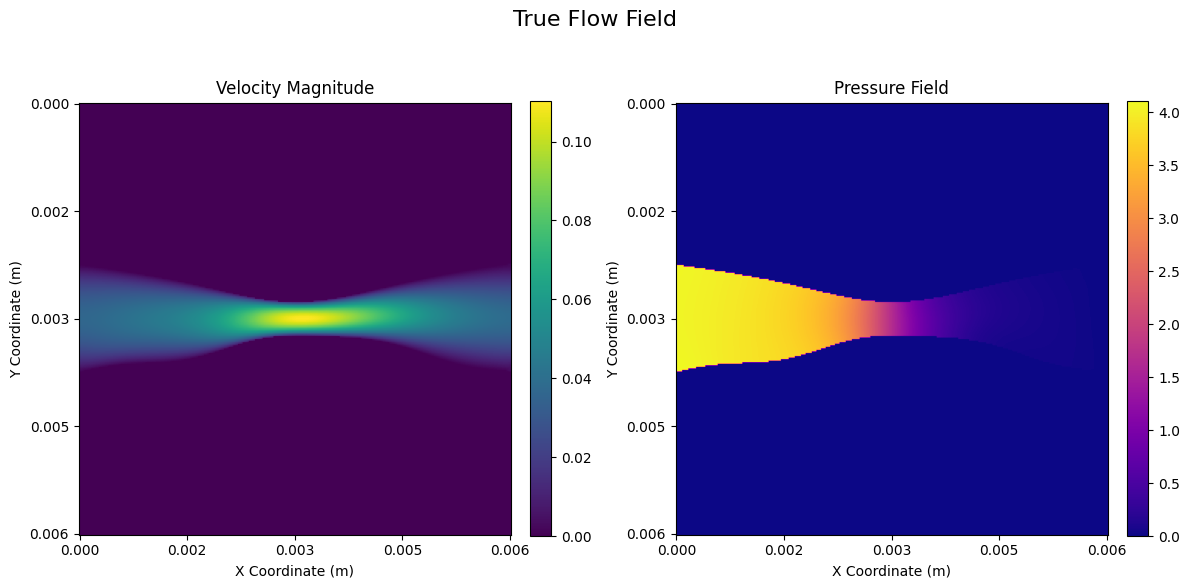

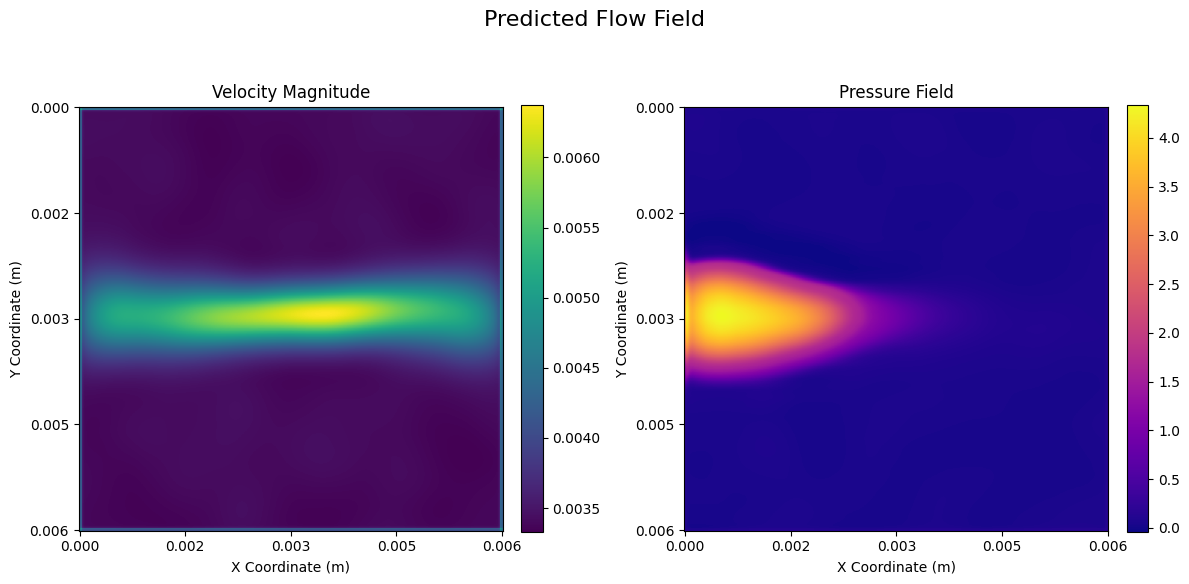

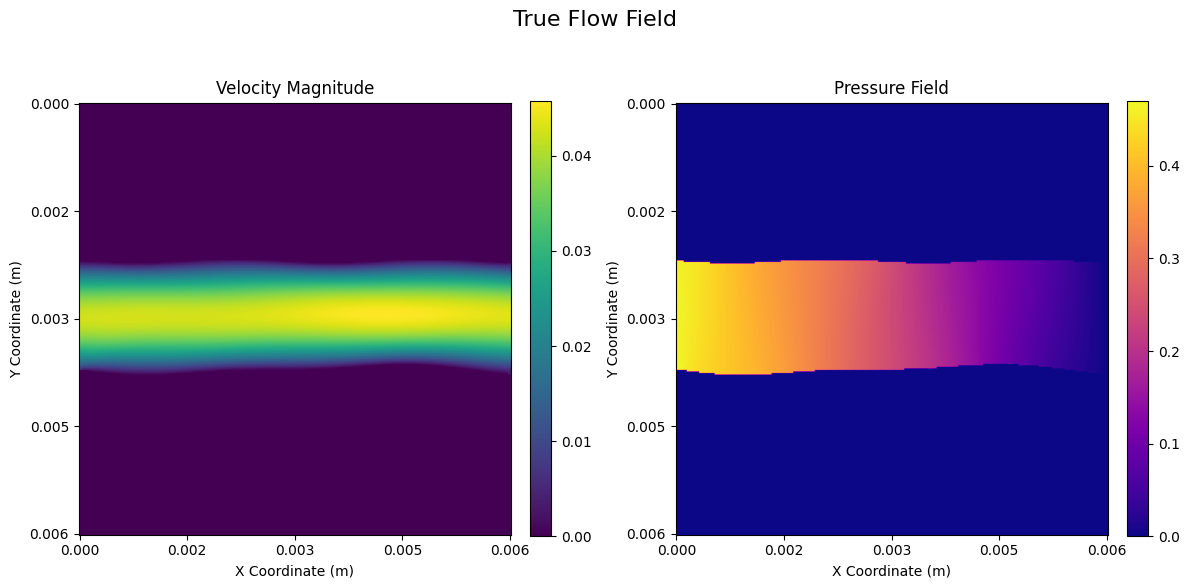

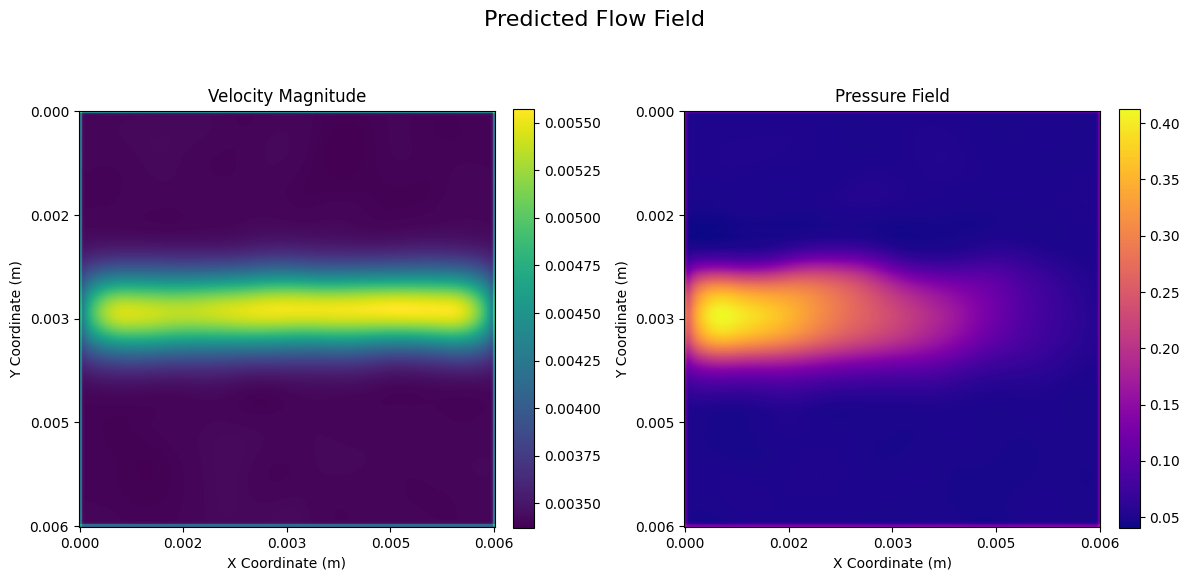

Test Loss: 0.046794255438726395


In [ ]:
test_model(model, test_loader, criterion, num_visualizations=3, device=device)